### Introduction
Script plots a PCA for the observed data, alongside a PCA using simulated data, utilising the medians of the priors.

### Imports
All imports occur here

In [89]:
import pandas as pd
from sim.model import SeqFeatures, WildcatSimulation
from sim import sum_stats as ss
import time
import tskit
import allel
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Choose parameters
Choose some parameters so it runs relatively quickly:

In [158]:
seq_features = SeqFeatures(length=int(20e6), recombination_rate=1.8e-8, mutation_rate=6e-8)

slim_parameters = {
    'pop_size_domestic_1': 2000,  # Population sizes are diploid.
    'pop_size_wild_1': 2000,
    'pop_size_captive': 70,
    'mig_rate_captive': 0.00,  # Migration from wild -> captive
    'mig_length_wild': 30,
    'mig_rate_wild': 0.008,  # Rate of migration from domestic -> wildcats
    'captive_time': 28,  # Time captive population established in SLiM
    }

recapitate_parameters = {
        'pop_size_domestic_2': 4000,
        'pop_size_wild_2': 4000,
        'div_time': 40000,
        'mig_rate_post_split': 0.005,
        'mig_length_post_split': 5000,
        'bottleneck_time_wild': 3000,
        'bottleneck_strength_wild': 20000,
        'bottleneck_time_domestic': 3000,
        'bottleneck_strength_domestic': 20000,
    }

### Run simulation

In [159]:
start_time = time.time()

# Run model
sim = WildcatSimulation(seq_features=seq_features, random_seed=40)
command = sim.slim_command(**slim_parameters)
decap_trees = sim.run_slim(command)
demographic_events = sim.demographic_model(**recapitate_parameters)
tree_seq = sim.recapitate(decap_trees, demographic_events)

# Print out useful bits and bobs
print("Simulation finished in {:.2f} s".format(time.time()-start_time))
print("Command ran: {}".format(command))


Simulation finished in 8.10 s
Command ran: slim -d pop_size_domestic_1=2000 -d pop_size_wild_1=2000 -d pop_size_captive=70 -d length=20000000 -d recombination_rate=1.8e-08 -d mig_rate_captive=0.0 -d mig_length_wild=30 -d mig_rate_wild=0.008 -d captive_time=28 -d decap_trees_filename='"../output/decap_40.trees"' -s 40 ./slim_model.slim


### Sample population

In [ ]:
samples = sim.sample_nodes(tree_seq, [5, 30, 10])  # Match number of samples to the WGS data
tree_seq = tree_seq.simplify(samples=np.concatenate(samples))

In [ ]:
tree_seq = tskit.load("tree_seq.trees")
genotypes = tree_seq.genotype_matrix()
pop_list = 5*["domestic"] + 30*["wild"] + 10*["captive"]

In [ ]:
genotypes = ss.genotypes(tree_seq)
pos = ss.positions(tree_seq)
pop_list = ss.pop_list(tree_seq)
samples = ss.sampled_nodes(tree_seq)

### Check tsinfer ancestral state irrelevant toy example

In [ ]:
import joblib
joblib.dump(np.array(genotypes), "../output/test_genotypes.joblib")
joblib.dump(pos, "../output/test_pos.joblib")

In [ ]:
df = pd.DataFrame({"AB": [1,2,3], "AC": [5,4,5], "CC": [5,7,5]})

In [ ]:
[col for col in list(df) if "A" in col]

### Check tsinfer ancestral state irrelevant

In [ ]:
positions = np.loadtxt("../data/e3.012.pos", delimiter="\t", usecols=1)
genotypes = np.loadtxt("../data/e3.012", delimiter="\t", usecols=range(1, len(positions)+1))
genotypes = genotypes.T
assert len(positions) == genotypes.shape[0]

# For now just assume that missings are ancestral
genotypes[genotypes == -1] = 0


In [ ]:
# Cam read in with scikit allel but genotypes looks dodge
callset = allel.read_vcf("../data/e3.vcf")
pos = callset["variants/POS"]
genotypes = allel.GenotypeArray(callset["calldata/GT"])

In [ ]:
callset["samples"][0:3]

In [ ]:
def pca_pipeline(genotypes, pos, pop_list):
    genotypes, pos = ss.maf_filter(genotypes, pos)
    genotypes = genotypes.to_n_alt()  # 012 with ind as cols
    genotypes, pos = ss.ld_prune(genotypes, pos)
    pca_stats = ss.pca_stats(genotypes, pop_list)
    return pca_stats

In [ ]:
sample_info = pd.read_csv("../data/e3_sample_info.csv", usecols=["NAME", "SOURCE"])

# Ensure that individuals are in same order (after 012 conversion)
assert np.all(sample_info["NAME"] == np.loadtxt("../data/e3.012.indv", dtype=str))

pca_pipeline(genotypes, pos, sample_info["SOURCE"].to_list())

In [ ]:
import tsinfer

with tsinfer.SampleData(sequence_length=6) as sample_data:
    sample_data.add_site(0, [0, 1, 0, 0, 0], ["A", "T"])
    sample_data.add_site(1, [0, 0, 0, 1, 1], ["G", "C"])
    sample_data.add_site(2, [0, 1, 1, 0, 0], ["C", "A"])
    sample_data.add_site(3, [0, 1, 1, 0, 0], ["G", "C"])
    sample_data.add_site(4, [0, 0, 0, 1, 1], ["A", "C"])
    sample_data.add_site(5, [0, 1, 2, 0, 0], ["T", "G", "C"])

### Calculate summary statistics

In [ ]:
def pca_pipeline(genotypes, pos, pop_list):
    genotypes, pos = ss.maf_filter(genotypes, pos)
    genotypes = genotypes.to_n_alt()  # 012 with ind as cols
    genotypes, pos = ss.ld_prune(genotypes, pos)
    pca_stats = ss.pca_stats(genotypes, pop_list)
    return pca_stats

In [ ]:
summary_functions = [
    ss.tskit_stats(tree_seq, samples),
    ss.afs_stats(tree_seq, samples),
    ss.r2_stats(tree_seq, samples, [0, 1e6, 2e6, 4e6], labels=["0_1Mb", "1_2Mb", "2_4MB"]),
    ss.roh_stats(genotypes, pos, pop_list, seq_features.length),
    pca_pipeline(genotypes, pos, pop_list),
]

stats_dict = {"random_seed": sim.random_seed}  # Random seed acts as ID

for func in summary_functions:
    stat = func
    stats_dict = {**stats_dict, **stat}

In [ ]:
stats_dict

### Caluculate summary statistics

In [8]:
samples = sim.sample_nodes(tree_seq, [4, 45, 46])  # Match number of samples to the WGS data
tree_seq = tree_seq.simplify(samples=np.concatenate(samples))

# Calculate summary statistics
def pca_pipeline(genotypes, pos):
    genotypes, pos = ss.maf_filter(genotypes, pos)
    genotypes = genotypes.to_n_alt()  # 012 with ind as cols
    genotypes, pos = ss.ld_prune(genotypes, pos)
    pca_stats = ss.pca_stats(genotypes)
    return pca_stats

genotypes = ss.sampled_genotypes(tree_seq)  # scikit-allel format
pos = ss.positions(tree_seq)

# Using a list to call function in for loop so we can use try/except (in case any functions fail)
summary_functions = [
    sum_stats.tskit_stats(),
    sum_stats.afs_stats(),
    sum_stats.r2_stats(),
    sum_stats.roh_stats(genotypes, pos),
    pca_pipeline(genotypes, pos),
]

stats_dict = {"random_seed": sim.random_seed}  # Random seed acts as ID

for func in summary_functions:
    stat = func
    stats_dict = {**stats_dict, **stat}

AttributeError: module 'sim.sum_stats' has no attribute 'sampled_genotypes'

In [ ]:
coverage_stats = {'domestic_roh_cov_median': 0.9996666, 'domestic_roh_cov_iqr': 0.00022224444444440827, 'wild_roh_cov_median': 0.6211887222222223, 'wild_roh_cov_iqr': 0.19288330555555555, 'captive_roh_cov_median': 0.8555888222222222, 'captive_roh_cov_iqr': 0.10507222222222223}
coverage_stats["all_pops_roh_cov_median"] = np.median()

In [ ]:
np.all(prior_df[["mig_rate_wild", "mig_rate_post_split"]]<=1) & np.all(prior_df[["mig_rate_wild", "mig_rate_post_split"]]>=0)

### Calculate ROH

Below seems fine but we should probably filter minor alleles. With this a single mutation breaks a ROH... I think that is ok? Presumably v. informative for PODs?

In [ ]:
samples = sim.sample_nodes(tree_seq, [4, 45, 46])  # Match number of samples to the SNP data
tree_seq = tree_seq.simplify(samples=np.concatenate(samples))
sum_stats = SummaryStatistics(tree_seq, sim)
genotypes = sum_stats.sampled_genotypes()
is_homo = genotypes[:,:,0] == genotypes[:,:,1]

In [ ]:
roh_id = pd.DataFrame(np.cumsum(is_homo == False, axis=0))  # Increment ID with each heterozygote
roh_id["position"] = sim_tools.positions(tree_seq)
df = roh_id.melt(id_vars="position", var_name="individual", value_name="roh_id")
df = df.groupby(["individual", "roh_id"])["position"].max().reset_index()
df["roh_length"] = df.groupby('individual')['position'].diff(1)
df = df.dropna()  # Drops first "ROH" (as no previous heterozygote)
df = df.drop(columns = ["position", "roh_id"])
# pd.DataFrame({"population": sum_stats.individual_pop_list, "id": range(0, len(sum_stats.individual_pop_list))})

### PCA

#### Take a sample and get the genotypes

In [160]:
samples = sim.sample_nodes(tree_seq, [4, 45, 46])  # Match number of samples to the SNP data
tree_seq = tree_seq.simplify(samples=np.concatenate(samples))

In [161]:
genotypes = ss.genotypes(tree_seq)
pos = ss.positions(tree_seq)
pop_list = ss.pop_list(tree_seq)
samples = ss.sampled_nodes(tree_seq)

#### Check for LD

In [162]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

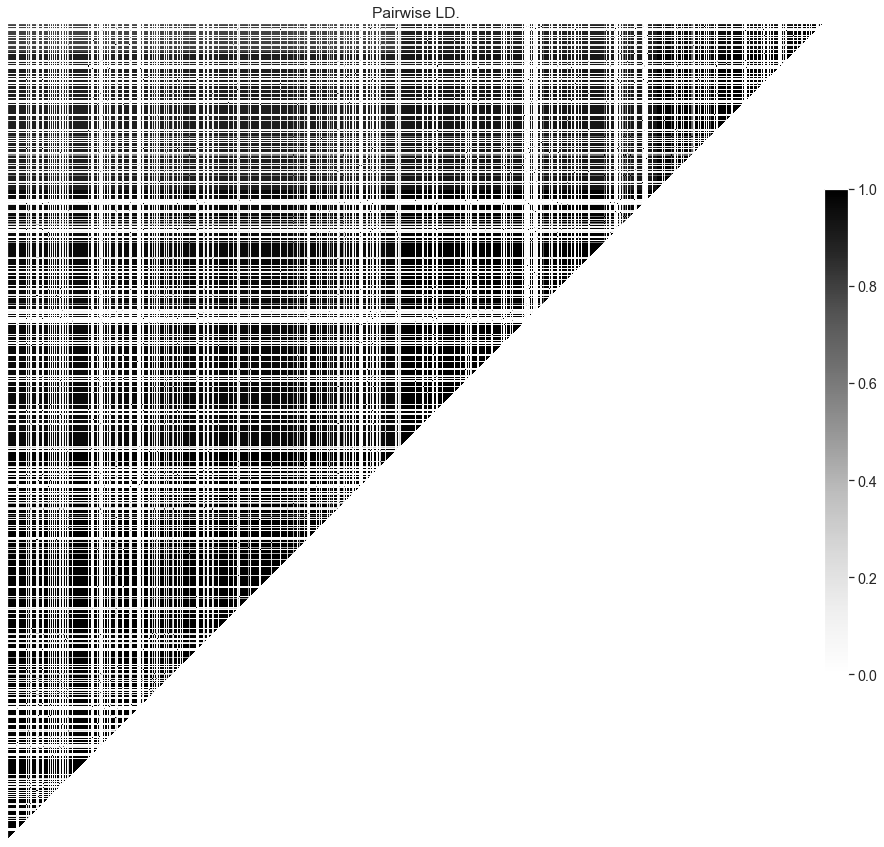

In [163]:
plot_ld(genotypes[:1000].to_n_alt(), 'Pairwise LD.')

#### Filter singletons and SNPs in LD
SNPs in LD can bias PCA.

In [164]:
genotypes, pos = ss.maf_filter(genotypes, pos)
genotypes, pos = ss.ld_prune(genotypes.to_n_alt(), pos)

ld_prune: Retaining: 13776  out of 156518 variants


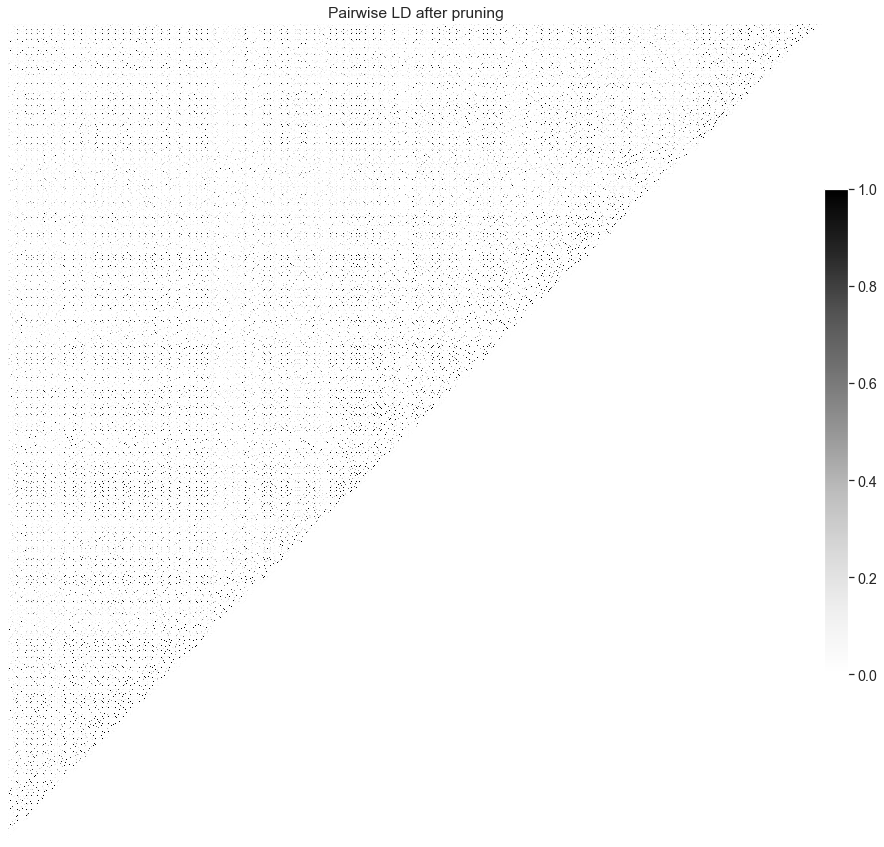

In [165]:
plot_ld(genotypes[:1000], 'Pairwise LD after pruning')

### Plot both

In [166]:
sample_population = np.asarray(["domestic"]*4 + ["wild"]*45 + ["captive"]*46)
populations = ["domestic", "wild", "captive"]
pop_colours = ["#FF0000", "#FFA500", "#0000FF"]

# Simulated data pca
coords, model = allel.pca(genotypes, n_components=10, scaler='patterson')
sim_df = pd.DataFrame({"pc1": coords[:, 0], "pc2": coords[:, 1],
                       "population": sample_population, "simulated_or_observed": "simulated"})

# Real data pca
real_genotypes = np.loadtxt("../data/snps.012", delimiter=" ", skiprows=1)
real_genotypes = real_genotypes[:,1:].transpose()  # Get rid of index and convert individuals to columns
coords, model = allel.pca(real_genotypes, n_components=2, scaler='patterson')
real_df = pd.DataFrame({"pc1": coords[:, 0], "pc2": coords[:, 1],
                   "population": sample_population, "simulated_or_observed": "observed"})

# Combined data
combined_df = sim_df.append(real_df)

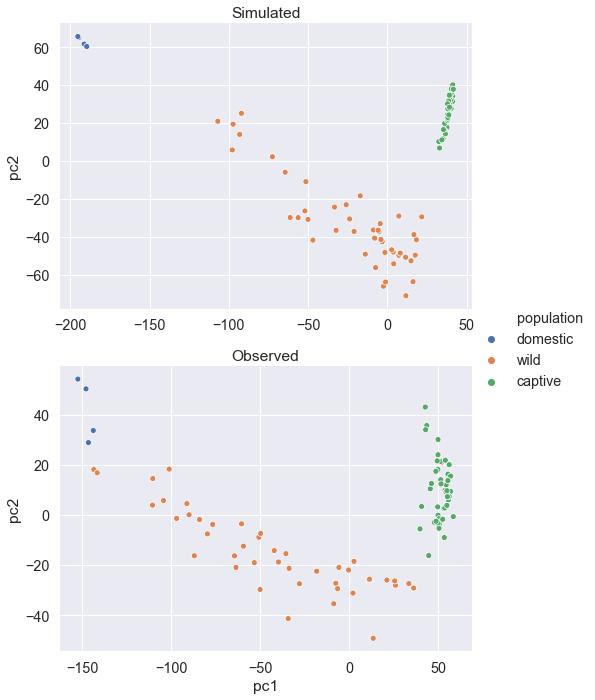

In [168]:
sns.set(style='darkgrid', font_scale=1.3)

g = sns.relplot(x="pc1", y="pc2",
                row="simulated_or_observed", hue="population",
                kind="scatter", data=combined_df,
                facet_kws=dict(sharex=False, sharey=False),
                aspect=1.4)

axes = g.axes.flatten()
axes[0].set_title("Simulated")
axes[1].set_title("Observed")

g.savefig("../plots/simulated_vs_observed_pca_mig_rate_0.png", dpi=600)